In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.animation as animation

In [493]:
dt = 60 * 60 # 1 hour
t_end = 5 * 86400 # 5 days
t = np.arange(0,t_end,dt)

# i and j index to 500
i = np.arange(0,500,1)
i_half = np.arange(0.5,500,1)
j = np.arange(0,500,1)
j_half = np.arange(0.5,500,1)

dx = 1000
x = np.arange(0,len(i)*dx,dx)
x_half = np.arange(0,len(i)*dx,dx) + round(np.diff(x).mean())/2

dy = 1000
y = np.arange(0,len(j)*dy,dy)
y_half = np.arange(0,len(j)*dy,dy) + round(np.diff(y).mean())/2

u = np.empty((len(i), len(j), len(t)))
v = np.empty((len(i), len(j), len(t)))
h = np.empty((len(i), len(j), len(t)))

tau_x = np.empty((len(i), len(j), len(t)))
tau_y = np.empty((len(i), len(j), len(t)))
# tau_x_half = np.empty((len(i), len(j), len(t)))
# tau_y_half = np.empty((len(i), len(j), len(t)))

## Wind Stress Arrays
Wind stress is only defined between 50000 and 200000 meters and only for the first 12 hours. Thus:
1. Wind stress = 0 when $\sqrt{x^2+y^2} < 200000$ and $\sqrt{x^2+y^2} > 50000$
2. Wind stress = 0 when $T < 86400/2$ where T is in seconds

Wind stress is stored in arrays that correspond to $x$ and $y$ in Cartesian coordinates.

All of this is to say:
1. Define tau_x on the same grid as u: (i_half,j). This is important since tau_x is based on position, and position of tau_x must correspond with position of u, since tau_x is only called in the equation for u.
2. Define tau_y on the same grid as v: (i,j_half). This is important since tau_y is based on position, and position of tau_y must correspond with position of v, since tau_y is only called in the equation for v.
3. The exact position only becomes important when we compute $\theta = \frac{y}{x}$.
4. From the position (for tau_x that is (x_half,y), for tau_y that is (x,y_half)), compute radius R. If R is less than $R_0$ and greater than $R_m$, find tau (NOT tau_x or tau_y since this is polar coordinates). Otherwise, tau is 0.
5. Additionally, only find tau when T is less than 12 hours
6. Get $\theta$ to computer tau_x and tau_y
> $\tau_x = \cos \theta$ \
> $\tau_y = \sin \theta$ 



In [494]:
rm = 50*1e3 # meters
r0 = 200e3
taum = 2
for I,value in enumerate(tau_x):
    for J,val in enumerate(value):
        for N,T in enumerate(val):
            if T <= 86400/2: # if T is less than 12 hours
                X = x_half[I]
                Y = y[J]
                R = np.sqrt(X**2+Y**2) # check if radius is less than r0
                if (R <= r0) & (R >= rm): # if radius less than r0
                    coeff = (R - r0)/(R - r0)
                    theta = np.arctan(Y/X)
                    tau = coeff * taum
                    taux = tau * np.cos(theta)
                    tau_x[I,J,N] = taux
                else:
                    # if radius is longer than r0, tau_x is 0
                    tau_x[I,J,N] = 0
            else:
                # if time is greater than 12 hours tau_x is 0
                tau_x[I,J,N] = 0
                
# for I,value in enumerate(tau_x_half):
#     for J,val in enumerate(value):
#         for N,T in enumerate(val):
#             if T <= 86400/2: # if T is less than 12 hours
#                 X = x_half[I]
#                 Y = y_half[J]
#                 R = np.sqrt(X**2+Y**2) # check if radius is less than r0
#                 if (R <= r0) & (R >= rm): # if radius less than r0
#                     coeff = (R - r0)/(R - r0)
#                     theta = np.arctan(Y/X)
#                     tau = coeff * taum
#                     taux = tau * np.cos(theta)
#                     tau_x_half[I,J,N] = taux
#                 else:
#                     # if radius is longer than r0, tau_x is 0
#                     tau_x_half[I,J,N] = 0
#             else:
#                 # if time is greater than 12 hours tau_x is 0
#                 tau_x_half[I,J,N] = 0
                
for I,value in enumerate(tau_y):
    for J,val in enumerate(value):
        for N,T in enumerate(val):
            if T <= 86400/2: # if T is less than 12 hours
                X = x[I]
                Y = y_half[J]
                R = np.sqrt(X**2+Y**2) # check if radius is less than r0
                if (R <= r0) & (R >= rm): # if radius less than r0
                    coeff = (R - r0)/(R - r0)
                    theta = np.arctan(Y/X)
                    tau = coeff * taum
                    tauy = tau * np.sin(theta)
                    tau_y[I,J,N] = tauy
                else:
                    # if radius is longer than r0, tau_y is 0
                    tau_y[I,J,N] = 0
            else:
                # if time is greater than 12 hours tau_y is 0
                tau_y[I,J,N] = 0
                
# for I,value in enumerate(tau_y_half):
#     for J,val in enumerate(value):
#         for N,T in enumerate(val):
#             if T <= 86400/2: # if T is less than 12 hours
#                 X = x_half[I]
#                 Y = y_half[J]
#                 R = np.sqrt(X**2+Y**2) # check if radius is less than r0
#                 if (R <= r0) & (R >= rm): # if radius less than r0
#                     coeff = (R - r0)/(R - r0)
#                     theta = np.arctan(Y/X)
#                     tau = coeff * taum
#                     tauy = tau * np.cos(theta)
#                     tau_y_half[I,J,N] = tauy
#                 else:
#                     # if radius is longer than r0, tau_y is 0
#                     tau_y_half[I,J,N] = 0
#             else:
#                 # if time is greater than 12 hours tau_y is 0
#                 tau_y_half[I,J,N] = 0

## Making a dataset to store everything

In [495]:
dsC = xr.Dataset(

    {

        "u": (["i_half", "j", "t"], u),

        "v": (["i", "j_half", "t"], v),
        
        "h": (["i", "j", "t"], h),
        
        "x": (["i"], x),
        
        "x_half": (["i_half"], x_half),
        
        "y": (["j"], y),
        
        "y_half": (["j_half"], y_half),
        
        "tau_x": (["i_half", "j", "t"], tau_x),
        
        # "tau_x_half": (["i_half", "j_half", "t"], tau_x_half),
        
        "tau_y": (["i", "j_half", "t"], tau_y),
        
        # "tau_y_half": (["i_half", "j_half", "t"], tau_y_half),

    },

    coords={

        "i_half": (["i_half"], i_half),

        "j_half": (["j_half"], j_half),

        "i": (["i"], i),
        
        "j": (["j"], j),

        "t": t,

    },

)

In [496]:
# Initial conditions
dsC['u'][:,:,0] = 0
dsC['v'][:,:,0] = 0
dsC['h'][:,:,0] = 0

In [497]:
dsC

<xarray.Dataset>
Dimensions:  (i_half: 500, j: 500, t: 120, i: 500, j_half: 500)
Coordinates:
  * i_half   (i_half) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * j_half   (j_half) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 491 492 493 494 495 496 497 498 499
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 491 492 493 494 495 496 497 498 499
  * t        (t) int64 0 3600 7200 10800 14400 ... 417600 421200 424800 428400
Data variables:
    u        (i_half, j, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (i, j_half, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (i, j, t) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    x        (i) int64 0 1000 2000 3000 4000 ... 496000 497000 498000 499000
    x_half   (i_half) float64 500.0 1.5e+03 2.5e+03 ... 4.985e+05 4.995e+05
    y        (j) int64 0 1000 2000 3000 4000 ... 496000 497000 498000 499000
    y_half   (j_half) float64 500.0 1.5e+03 2.5e+03 ... 4.985e+05 4.995e+05
    tau_x    (i_half, j, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tau_y    (i, j_half, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [530]:
gp = 9.8 * (1024-1020)/1024
H = 1000
p = 1020
f = 1e-4
for n,T in enumerate(t):
    for I,i_val in enumerate(i):
        for J,j_val in enumerate(j):
            if I < i.max():
                if n < len(t)-2:
                    if J < j.max():
                        I_half = I
                        J_half = J
                        i_half_val = dsC['i_half'][I_half]
                        j_half_val = dsC['j_half'][J_half]
                        
                        # Calling J_half-1 when J_half is 0 (aka 1/2) will have Python call the last index of J_half
                        # which should be fine as long as v at max(J_half) is initially 0
                        vbar = ((dsC['v'][I+1,J_half,n] - dsC['v'][I+1,J_half-1,n])/2 + (dsC['v'][I,J_half,n] - dsC['v'][I,J_half-1,n])/2)/2
                        dsC['u'][I_half,J,n+1] = -dt * gp * (dsC['h'][I+1,J,n] - dsC['h'][I,J,n])/dx + (dt)/(H*p) * dsC['tau_x'][I_half,J,n] + vbar * f * dt + dsC['u'][I_half,J,n]
                    
                        ubar = ((dsC['u'][I_half,J+1,n] - dsC['u'][I_half-1,J+1,n])/2 + (dsC['u'][I_half,J,n] - dsC['u'][I_half-1,J,n])/2)/2
                        dsC['v'][I,J_half,n+1] = -dt * gp * (dsC['h'][I+1,J,n] - dsC['h'][I,J,n])/dy + (dt)/(H*p) * dsC['tau_y'][I,J_half,n] - ubar * f * dt + dsC['v'][I,J_half,n]
                    
                        dsC['h'][I,J,n+1] = -dt * H * ( (dsC['u'][I_half,J,n] - dsC['u'][I_half-1,J,n])/dx + (dsC['v'][I,J_half,n] - dsC['v'][I,J_half-1,n])/dy ) + dsC['h'][I,J,n]

KeyboardInterrupt: 

In [544]:
dsC['tau_x'][:,:,10].max().values

array(2.)

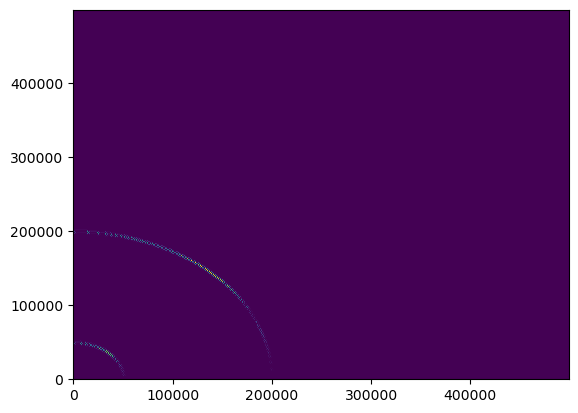

In [545]:
plt.pcolormesh(x,y,dsC['h'][:,:,10], vmin = 0)

In [529]:
dsC['tau_x']

<xarray.DataArray 'tau_x' (i_half: 500, j: 500, t: 120)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * i_half   (i_half) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 491 492 493 494 495 496 497 498 499
  * t        (t) int64 0 3600 7200 10800 14400 ... 417600 421200 424800 428400